## Face Recognition with Custom Model (Inspired and replicated almost similar network from this paper: https://iopscience.iop.org/article/10.1088/1742-6596/1395/1/012006/pdf)

In [1]:
!nvidia-smi

Thu Oct  5 13:32:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    30W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


In [6]:
!unzip -q FaceRecognition.zip

In [1]:
cd /content/drive/MyDrive/FaceRecognition

/content/drive/MyDrive/FaceRecognition


In [2]:
ls

faceRecogniser.pt  inception_resnet_v1.py  __pycache__/  train/  utils/  val/


In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, transforms, utils, datasets
import time
import os
from pathlib import Path
import matplotlib.pyplot as plt

In [54]:
# Dataset Creation/Transformation and Conversion to Iterable-Dataloader
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size=(300, 300)),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize(size=(300, 300)),
        transforms.ToTensor(),
    ]),
}

data_dir = '/content/drive/MyDrive/FaceRecognition/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8, shuffle=True) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes

In [5]:
# CLASSES/PEOPLES NAMES
class_names

['Anupama', 'Kaifeng', 'Revanth']

In [41]:
dataset_sizes

{'train': 199, 'val': 53}

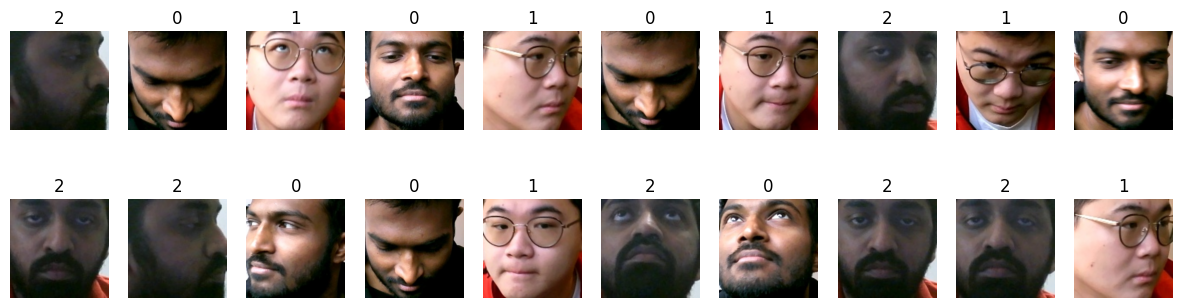

In [55]:
# Get Random 20 images.
torch.manual_seed(42)

fig = plt.figure(figsize=(15, 4))
rows, cols = 2, 10
for i in range(1, rows*cols+1):
    randidx = torch.randint(0, len(dataloaders['train'].dataset), size=[1]).item()
    img, label = dataloaders['train'].dataset[randidx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(label)
    plt.axis(False)

In [8]:
# Print dimensions of single sample
train_data = image_datasets['train']
img, label = train_data[0]
img.shape, label

(torch.Size([3, 300, 300]), 0)

In [9]:
class FaceRecognitionV0(nn.Module):
  def __init__(self, input_features, output_features):
    super().__init__()
    self.conv_blocks = nn.Sequential(
        nn.Conv2d(in_channels=input_features, out_channels=36, kernel_size=(3,3)),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(in_channels=36, out_channels=76, kernel_size=(3,3)),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2))
    )
    self.linear_layers = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(p=0.20),
        nn.Linear(in_features=405004, out_features=1024),
        nn.Dropout(p=0.20),
        nn.Linear(in_features=1024, out_features=len(class_names))
    )

  def forward(self, x):
    return self.linear_layers(self.conv_blocks(x))
    return x

In [10]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [11]:
# Model Initialisation
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_0 = FaceRecognitionV0(input_features=3, output_features=len(class_names))
model_0.to(device)
model_0

FaceRecognitionV0(
  (conv_blocks): Sequential(
    (0): Conv2d(3, 36, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(36, 76, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=405004, out_features=1024, bias=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=1024, out_features=3, bias=True)
  )
)

In [12]:
# Sample Run
out = model_0(img.unsqueeze(0).to(device))
out.shape, out

(torch.Size([1, 3]),
 tensor([[-0.0399, -0.0097,  0.0345]], device='cuda:0',
        grad_fn=<AddmmBackward0>))

In [116]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 11.7 MB/s eta 0:00:00


In [13]:
# Setup loss fn, optimiser, accuracy
from torchmetrics import Accuracy

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.01)
acc_fn = Accuracy(task="multiclass", num_classes=len(class_names)).to(device)

In [14]:
# Training and Testing model
from tqdm.auto import tqdm

epochs = 20

for epoch in tqdm(range(epochs)):
  model_0.train()

  train_loss, train_acc = 0.0, 0.0

  for batch, (X_train, y_train) in enumerate(iter(dataloaders['train'])):
    X_train = X_train.to(device)
    y_train = y_train.to(device)

    # Predictions/Forward Pass
    y_logits = model_0(X_train)
    y_preds = torch.argmax(y_logits, dim=1)

    # Loss, acc
    loss = loss_fn(y_logits, y_train)
    train_loss += loss
    train_acc += acc_fn(y_preds, y_train)

    # zero gradient
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # Gradient Descent
    optimizer.step()

  # Avg for epoch
  train_loss /= len(dataloaders['train'])
  train_acc /= len(dataloaders['train'])

  test_loss, test_acc = 0.0, 0.0

  model_0.eval()
  with torch.inference_mode():
    for (X_test, y_test) in dataloaders['val']:
      X_test, y_test = X_test.to(device), y_test.to(device)

      y_logits = model_0(X_test)
      y_preds = torch.argmax(y_logits, dim=1)

      test_loss += loss_fn(y_logits, y_test)
      test_acc += acc_fn(y_preds, y_test)

    test_loss /= len(dataloaders['val'])
    test_acc /= len(dataloaders['val'])

  print(f"Epoch: {epoch} | Train Loss: {train_loss} Acc: {train_acc} | Test Loss: {test_loss} Acc: {test_acc}")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 270.3948669433594 Acc: 0.6042856574058533 | Test Loss: 0.013245449401438236 Acc: 0.9821429252624512
Epoch: 1 | Train Loss: 0.629348635673523 Acc: 0.9300000071525574 | Test Loss: 0.000458611233625561 Acc: 1.0
Epoch: 2 | Train Loss: 0.024209631606936455 Acc: 0.9899999499320984 | Test Loss: 0.006894291378557682 Acc: 1.0
Epoch: 3 | Train Loss: 0.000586681766435504 Acc: 1.0 | Test Loss: 0.000611752038821578 Acc: 1.0
Epoch: 4 | Train Loss: 0.0004810326499864459 Acc: 1.0 | Test Loss: 0.0005454722559079528 Acc: 1.0
Epoch: 5 | Train Loss: 0.00045760555076412857 Acc: 1.0 | Test Loss: 0.0005508814356289804 Acc: 1.0
Epoch: 6 | Train Loss: 0.0004031155549455434 Acc: 1.0 | Test Loss: 0.0004720725119113922 Acc: 1.0
Epoch: 7 | Train Loss: 0.0003725485294125974 Acc: 1.0 | Test Loss: 0.00044434104347601533 Acc: 1.0
Epoch: 8 | Train Loss: 0.00034585437970235944 Acc: 1.0 | Test Loss: 0.00045092139043845236 Acc: 1.0
Epoch: 9 | Train Loss: 0.000284831621684134 Acc: 1.0 | Test Loss: 0.

In [15]:
# Lets test the model on test/val set

model_0.eval()

test_loss, test_acc = 0.0, 0.0
with torch.inference_mode():
  for (X_test, y_test) in dataloaders['val']:
    X_test, y_test = X_test.to(device), y_test.to(device)

    y_logits = model_0(X_test)
    y_pred = torch.argmax(y_logits, dim=1)

    test_loss += loss_fn(y_logits, y_test)
    test_acc += acc_fn(y_pred, y_test)

  test_loss /= len(dataloaders['val'])
  test_acc /= len(dataloaders['val'])

print(f"Test Loss: {test_loss} Acc: {test_acc}")

Test Loss: 0.0002115526731358841 Acc: 1.0


T: True Label | P: Predicted label


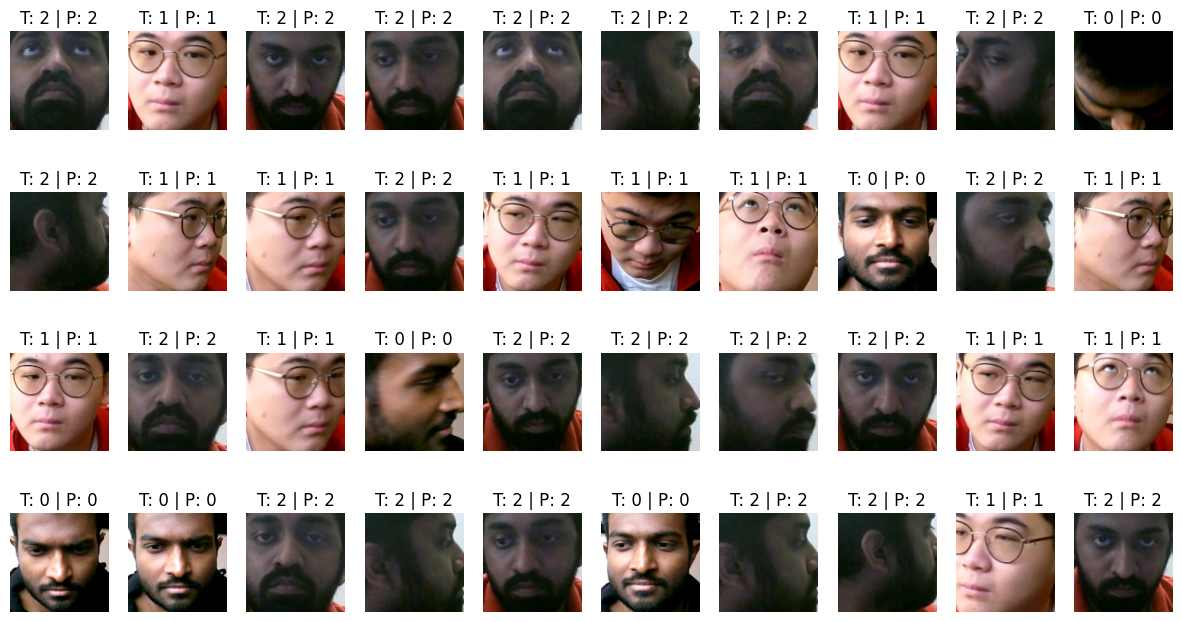

In [19]:
# Get Random 20 images.
torch.manual_seed(42)

fig = plt.figure(figsize=(15, 8))
rows, cols = 4, 10
model_0.eval()
with torch.inference_mode():
  for i in range(1, rows*cols+1):
      randidx = torch.randint(0, len(dataloaders['val'].dataset), size=[1]).item()
      img, label = dataloaders['val'].dataset[randidx]

      # Making preds
      pred_label = torch.argmax(model_0(img.unsqueeze(dim=0).to(device)), dim=1).item()

      # Plots
      fig.add_subplot(rows, cols, i)
      plt.imshow(img.permute(1, 2, 0))
      plt.title(f"T: {label} | P: {pred_label}")
      plt.axis(False)

print("T: True Label | P: Predicted label")

In [21]:
# Save the best model

MODEL_DIR = Path("Models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "FaceRecognitionV0.pt"
MODEL_PATH = MODEL_DIR / MODEL_NAME

torch.save(model_0.state_dict(), MODEL_PATH)

In [25]:
# Load the model
loaded_model_0 = FaceRecognitionV0(input_features=3, output_features=len(class_names))
loaded_model_0.load_state_dict(torch.load(MODEL_PATH))
loaded_model_0.to(device)

FaceRecognitionV0(
  (conv_blocks): Sequential(
    (0): Conv2d(3, 36, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(36, 76, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=405004, out_features=1024, bias=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=1024, out_features=3, bias=True)
  )
)

In [86]:
# Getting Predictions to plot confusion matrix

loaded_model_0.eval()

test_loss, test_acc = 0.0, 0.0
predictions = []
actual = []

with torch.inference_mode():
  for (X_test, y_test) in tqdm(dataloaders['val']):
    X_test, y_test = X_test.to(device), y_test.to(device)
    actual.append(y_test.cpu())

    y_logits = loaded_model_0(X_test)
    y_pred = torch.argmax(y_logits, dim=1)
    predictions.append(y_pred.cpu())

    test_loss += loss_fn(y_logits, y_test)
    test_acc += acc_fn(y_pred, y_test)

  test_loss /= len(dataloaders['val'])
  test_acc /= len(dataloaders['val'])

predictions = torch.cat(predictions)
actual = torch.cat(actual)

print(f"Test Loss: {test_loss} Acc: {test_acc}")
print("Predictions: ", predictions)

  0%|          | 0/7 [00:00<?, ?it/s]

Test Loss: 0.0002583540335763246 Acc: 1.0
Predictions:  tensor([0, 1, 0, 2, 2, 0, 0, 2, 1, 0, 0, 0, 1, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2,
        2, 0, 1, 2, 0, 1, 2, 0, 0, 2, 1, 1, 2, 0, 0, 0, 2, 0, 1, 2, 0, 2, 2, 0,
        1, 1, 1, 0, 1])


In [87]:
# Confusion Matrix
from torchmetrics import ConfusionMatrix

cm = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
matrix = cm(predictions, actual)
matrix

tensor([[19,  0,  0],
        [ 0, 13,  0],
        [ 0,  0, 21]])

(<Figure size 1200x1200 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

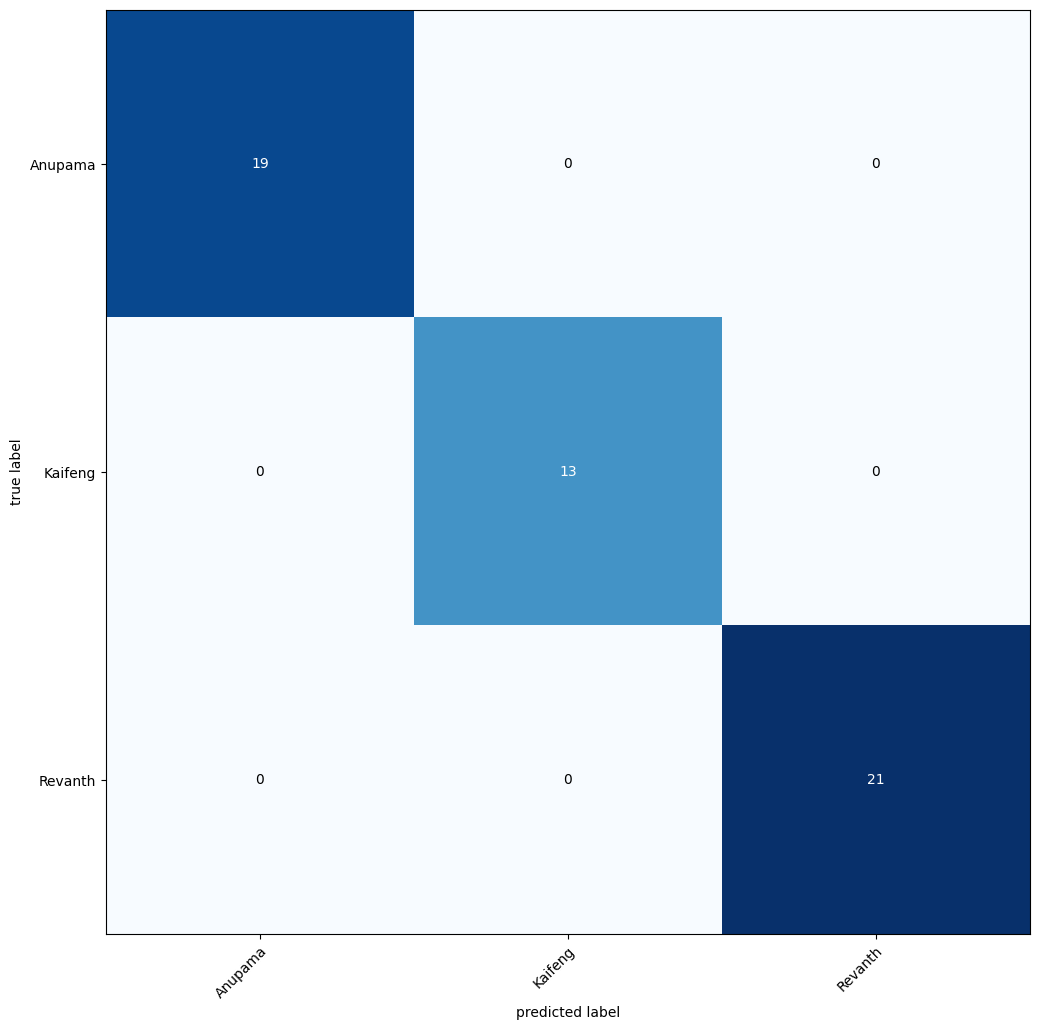

In [88]:
import mlxtend
from mlxtend.plotting import plot_confusion_matrix

plot_confusion_matrix(conf_mat=matrix.numpy(), class_names=class_names, figsize=(12, 12))